### Sanket Patel 
### 8900086

Data Extraction and selecting top 3 classes

In [1]:
import os, shutil, pathlib 
import pandas as pd


In [2]:
#selecting data from the kaggle downloaded dataset
data_path_train= "./data/train/"
data_path_test= "./data/test/"
data_path_val= "./data/valid/"

class_names= os.listdir(data_path_train)

class_image_count=[]

In [3]:

    for file in class_names:
        file_path = os.path.join(data_path_train,file)
        if os.path.isdir(file_path):
            file_count= len(os.listdir(file_path))
            class_image_count.append((file,file_count))

In [4]:
#List of top 3 classes
class_image_countdf= pd.DataFrame(class_image_count, columns=['class','count'])
top3= class_image_countdf.nlargest(3, 'count')
top3

,class,count
434,RUFOUS TREPE,263
291,HOUSE FINCH,248
184,D-ARNAUDS BARBET,233


In [7]:
new_path_train = './data_new/train'
os.makedirs(new_path_train, exist_ok=True)

for _,row in top3.iterrows():
    class_name = row['class']
    src_folder= os.path.join(data_path_train, class_name)
    dst_folder= os.path.join(new_path_train, class_name)
    shutil.copytree(src_folder, dst_folder)
print('Done')

Done


In [8]:
new_path_test = './data_new/test'
os.makedirs(new_path_test, exist_ok=True)
for _,row in top3.iterrows():
    class_name = row['class']
    src_folder= os.path.join(data_path_test, class_name)
    dst_folder= os.path.join(new_path_test, class_name)
    shutil.copytree(src_folder, dst_folder)


In [9]:
new_path_valid = './data_new/valid'
os.makedirs(new_path_valid, exist_ok=True)
for _,row in top3.iterrows():
    class_name = row['class']
    src_folder= os.path.join(data_path_val, class_name)
    dst_folder= os.path.join(new_path_valid, class_name)
    shutil.copytree(src_folder, dst_folder)


### Selecting data after selecting top 3 classes


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

In [12]:
data_folder = pathlib.Path("./data_new/")

train_data = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_data = image_dataset_from_directory(
    data_folder / "valid",
    image_size=(180, 180),
    batch_size=32)
test_data = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


Using Image data generator for data augmentation

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import seaborn as sns
train_aug = ImageDataGenerator(
    rescale=1/255, 
    rotation_range=15,
    zoom_range=0.1,
    )
test_aug = ImageDataGenerator(rescale=1/255)

In [57]:
#giving dataset from the data augmentation

train_dataset_gen= train_aug.flow_from_directory(
    "./data_new/train",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)
validatation_dataset_gen= train_aug.flow_from_directory(
    "./data_new/valid",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')



Found 744 images belonging to 3 classes.


Found 15 images belonging to 3 classes.


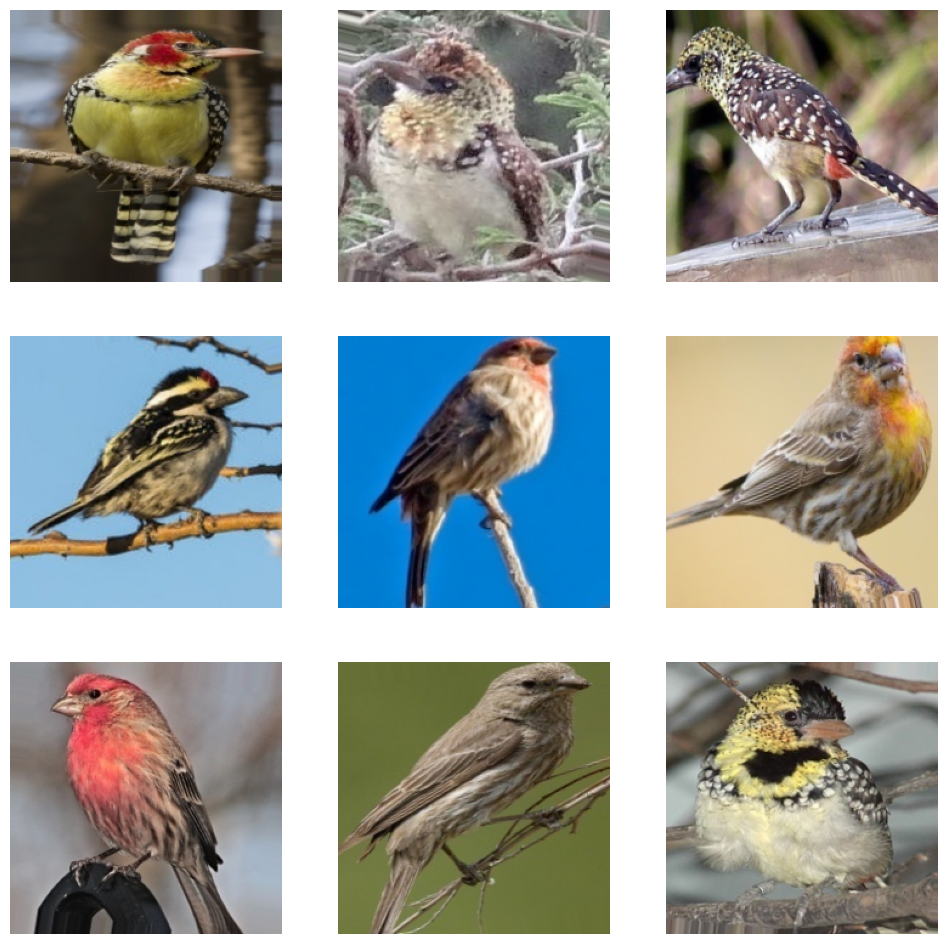

In [58]:
train_folder = "./data_new/train"
class_folders = os.listdir("./data_new/train")
sample_images, _ = next(train_dataset_gen)

plt. figure(figsize=(12, 12))

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis("off")
plt.show()

   


### using Vgg16 for fine tuning

In [59]:
#fine tune vgg16
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D







In [60]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Freezing the layers of vgg16 

In [61]:
for layer in vgg16.layers:
    layer.trainable = False


In [64]:
from keras.models import Sequential
model= Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [65]:
history = model.fit(
    train_dataset_gen,
    epochs=10,
    steps_per_epoch= len(train_dataset_gen),
    validation_data=validatation_dataset_gen,
    validation_steps=len(validatation_dataset_gen)
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./data_new/model.h5",
        save_best_only=True,
        monitor="val_loss")
]

Epoch 1/10
24/24 [==============================] - 73s 3s/step - loss: 1.6506 - accuracy: 0.6841 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 74s 3s/step - loss: 0.2653 - accuracy: 0.9153 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 76s 3s/step - loss: 0.1298 - accuracy: 0.9556 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 78s 3s/step - loss: 0.0549 - accuracy: 0.9785 - val_loss: 8.9961e-04 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 78s 3s/step - loss: 0.0660 - accuracy: 0.9785 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 79s 3s/step - loss: 0.0409 - accuracy: 0.9866 - val_loss: 7.0624e-04 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 79s 3s/step - loss: 0.0435 - accuracy: 0.9812 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 8/10
2

plotting the graphs for traning and validation accuracy

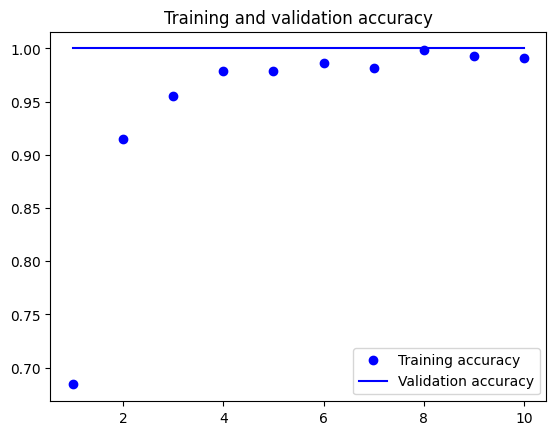

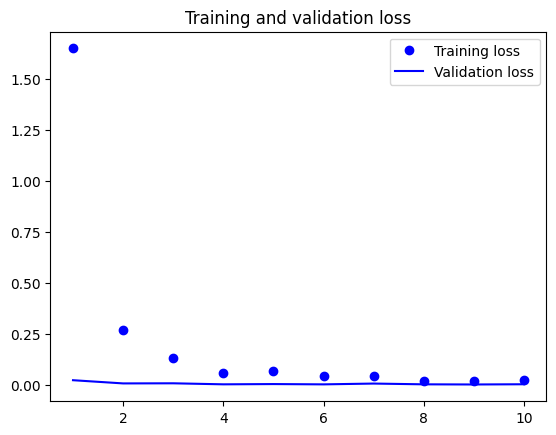

In [66]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [67]:
#save model
model.save('model.h5')

In [68]:
testLoss, testAcc = model.evaluate(validatation_dataset_gen)
print(f"Test accuracy: {testAcc:.3f}")

1/1 [==============================] - 2s 2s/step - loss: 0.0015 - accuracy: 1.0000
Test accuracy: 1.000


In [92]:
#confusion matrix, precision, recall and f1 score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred = model.predict(validatation_dataset_gen)
y_pred_class= np.argmax(y_pred, axis=1)
y_true = validatation_dataset_gen.classes



1/1 [==============================] - 1s 1s/step


In [94]:

from sklearn.metrics import classification_report
confusion= confusion_matrix(y_true, y_pred_class)
#print classification_report
print(confusion)
print(classification_report(y_true, y_pred_class, target_names=validatation_dataset_gen.class_indices.keys()))

[[1 2 2]
 [2 2 1]
 [2 1 2]]
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.20      0.20      0.20         5
     HOUSE FINCH       0.40      0.40      0.40         5
    RUFOUS TREPE       0.40      0.40      0.40         5

        accuracy                           0.33        15
       macro avg       0.33      0.33      0.33        15
    weighted avg       0.33      0.33      0.33        15



AUC for D-ARNAUDS BARBET: 0.42012987012987013
AUC for HOUSE FINCH: 0.48784715284715285
AUC for RUFOUS TREPE: 0.6751731601731602


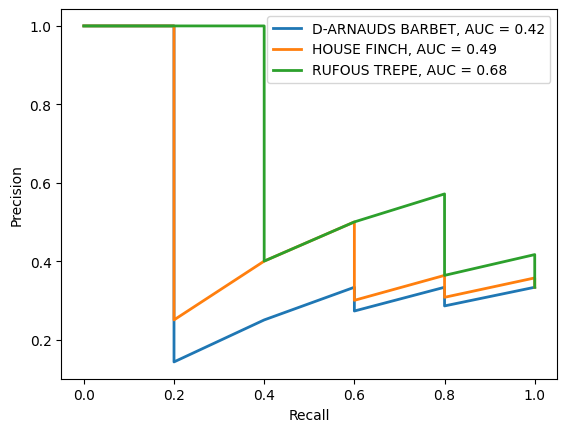

In [96]:
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve, auc
y_trueHot = to_categorical(y_true)
class_names = {i: j for j, i in validatation_dataset_gen.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_trueHot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Incorrect predicted data

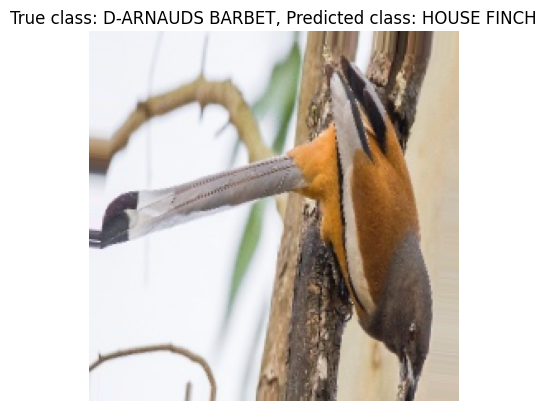

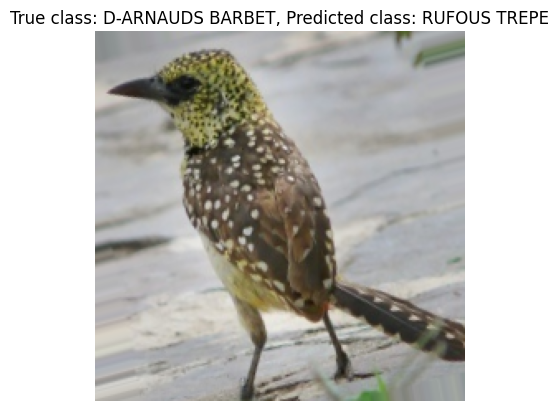

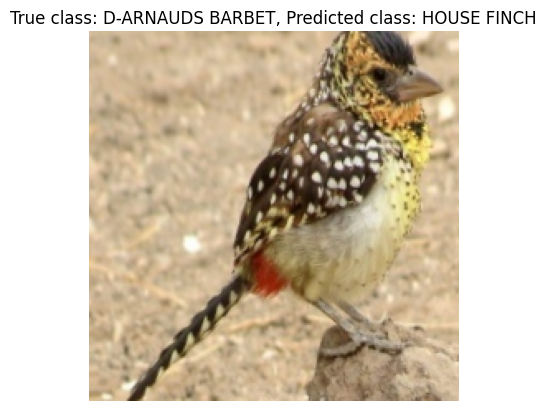

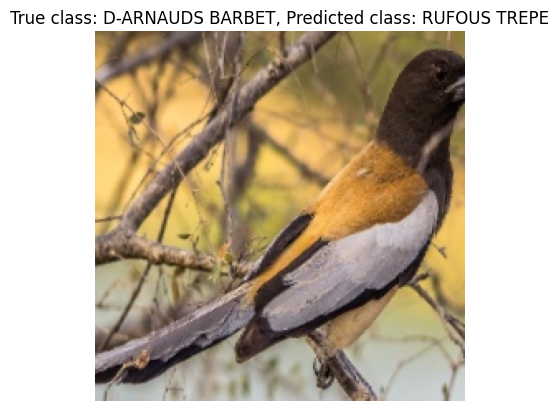

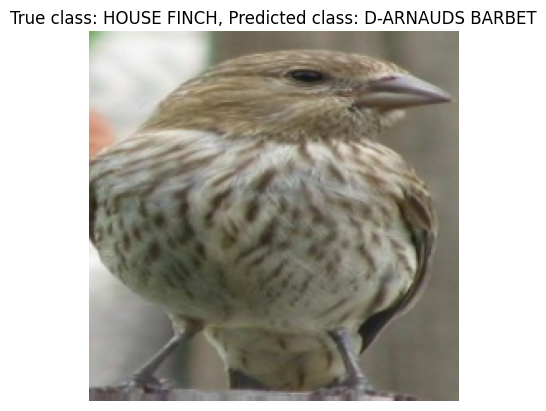

In [104]:
incorrect = np.where(y_pred_class != y_true)[0]

# plot specific examples
for i in incorrect[:5]:
    # get image from corresponding batch
    img_batch, _ = validatation_dataset_gen[i // validatation_dataset_gen.batch_size]
    img = img_batch[i % validatation_dataset_gen.batch_size]

    true_class_name = class_names[y_true[i]]
    predicted_class_name = class_names[y_pred_class[i]]

    plt.imshow(img)
    plt.title(f'True class: {true_class_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()